In [1]:
import pandas as pd
import numpy as np

working = pd.read_parquet('le_states.parquet')
df = working[['callsign', 'lat', 'lon', 'lastposupdate']]

# Empty dataframes tell Datashader to 'lift the pen up' when drawing lines
empty=df[:1].copy()
empty.loc[0, 'callsign'] = 'PENUP'
empty.loc[0, 'lastposupdate'] = 0
empty.loc[0, 'lat'] = np.NaN
empty.loc[0, 'lon'] = np.NaN

paths = []

# Given the working state vectors, reorder by flight with empty rows between
for callsign, group in df.groupby('callsign', as_index=False):
  times = group.lastposupdate
  splits = np.split(group.reset_index(drop=True), np.where(times.diff()>600)[0])
  for split_df in splits:
    paths += [split_df]

split = pd.concat(paths,ignore_index=True)

/Users/bmilk/Projects/le-birds/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


/Users/bmilk/Projects/le-birds/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


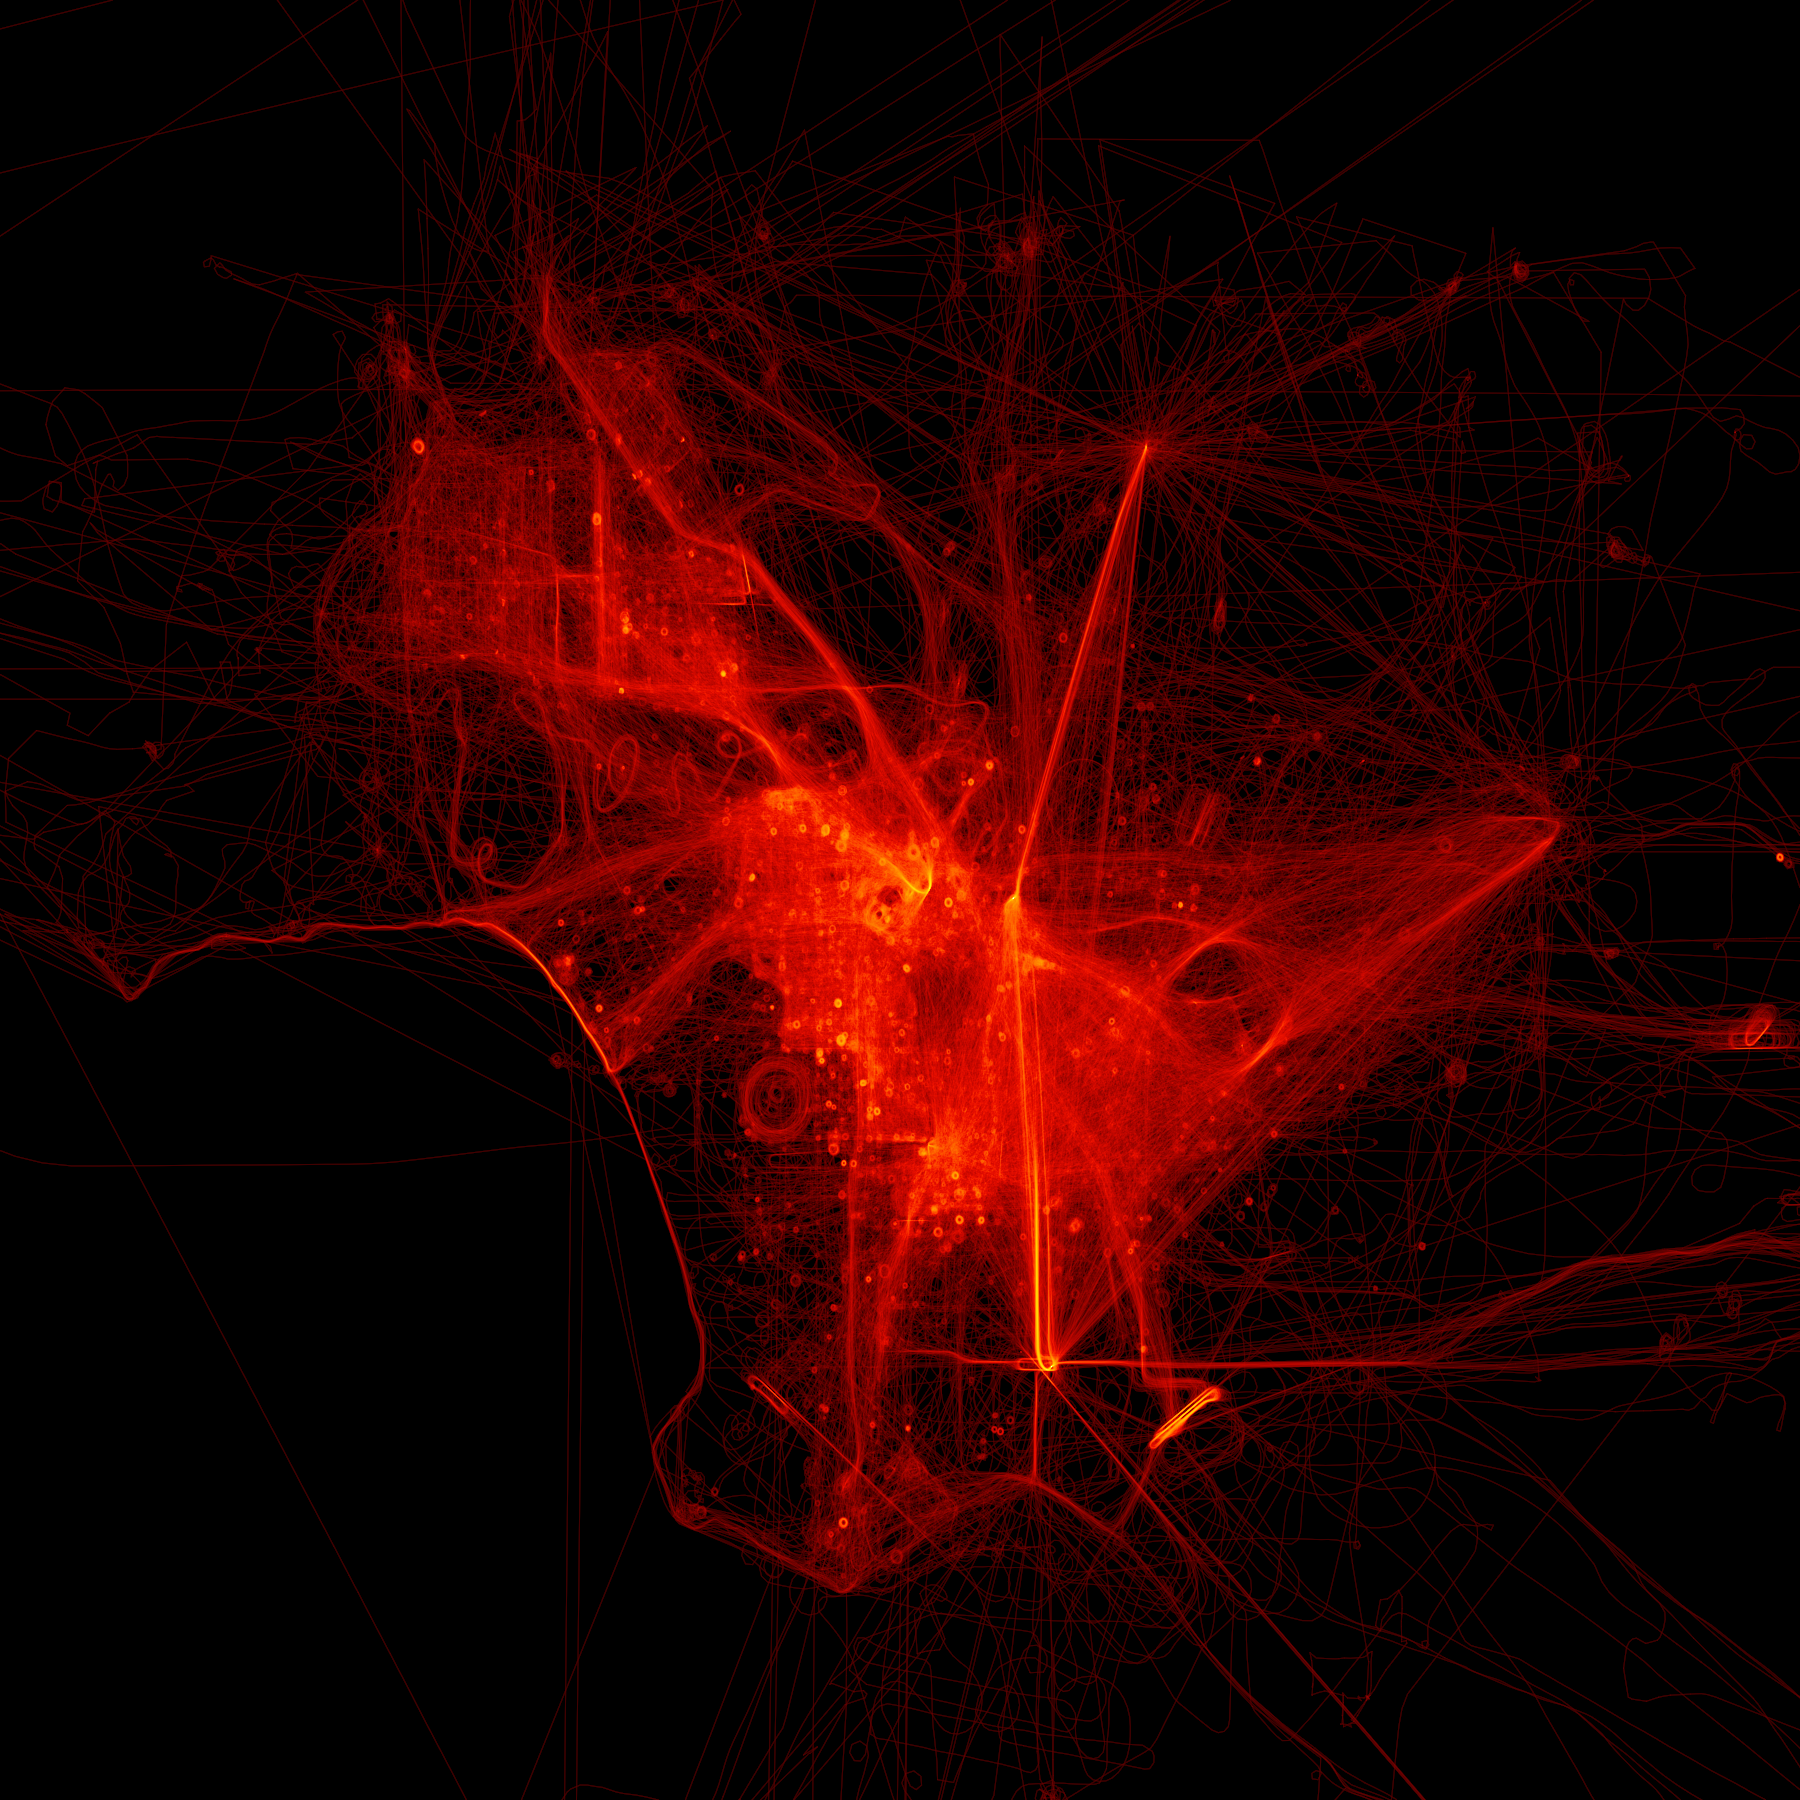

In [2]:
import datashader as ds, colorcet
from datashader import antialias

# Define a set of plot boundaries containing a geographic square over the county of Los Angeles
# N.B. these coordinates are rough and were generated by Copilot based on the prompt above
x_range_la = (-118.9, -117.6)
y_range_la = (33.6, 34.5)

canvas = ds.Canvas(plot_width=1800, plot_height=1800, x_range=x_range_la, y_range=y_range_la)
agg = canvas.line(split, 'lon', 'lat', ds.count(), antialias = True)
img = ds.tf.shade(agg, how='log', cmap=colorcet.fire)
img = ds.tf.set_background(img, 'black')

# Given the canvas 'agg', save a png to disk
ds.utils.export_image(img, 'le_birds', fmt='.png')